# Clasificador Naive Bayes
El objetivo del notebook es experimentar con el clasificador Naive Bayes en sus diferentes implementaciones. Se utilizarán los clasificadores gausiano para clasificación multiclase en el conjunto iris, multinomial para clasificación binaria de mensajes de texto y bernoulli para clasificación multiclase de animales.

## Iris Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn import datasets

Función de utilizad para visualizar matriz de confusión.

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
        
    Reference
    -------
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(fig)

### Carga del dataset y exploración

In [ ]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


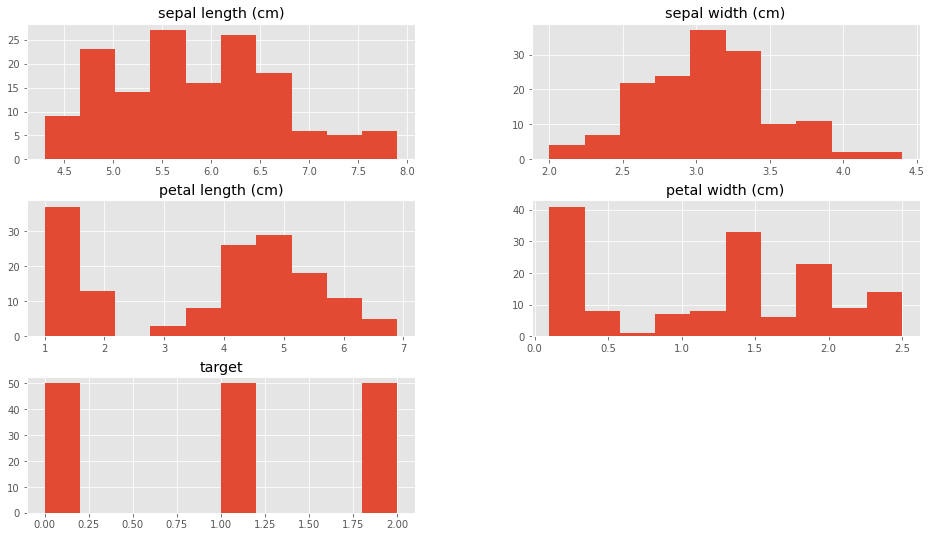

In [ ]:
iris_df.hist()
plt.show()

### Separación en cojuntos de entrenamiento y validación, normalización

In [ ]:
X = iris_df[iris['feature_names']].values
y = iris_df['target'].values
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Entrenamiento y evaluación de un clasificador gausiano

In [ ]:
gnb = GaussianNB() #NaiveBayes Gaussiano
model = gnb.fit(X_train, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.95
Accuracy of GaussianNB classifier on test set: 1.00


Matriz de confusión en el conjunto de validación.

Figure(720x504)


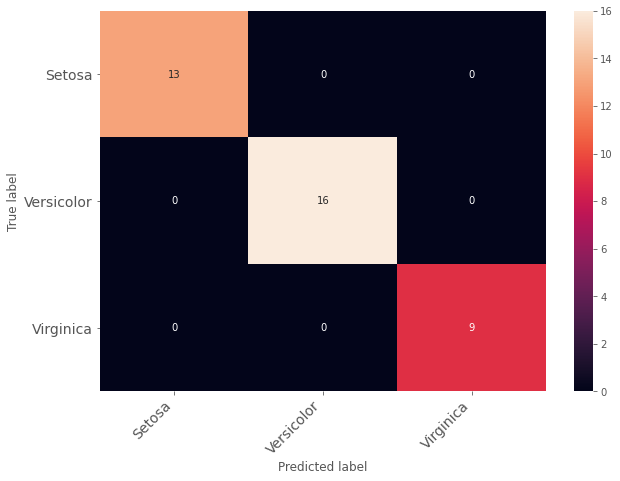

In [ ]:
pred = gnb.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test, pred),["Setosa","Versicolor","Virginica"])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        16
         2.0       1.00      1.00      1.00         9

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



Matriz de confusión en el conjunto de entrenamiento.

Figure(720x504)


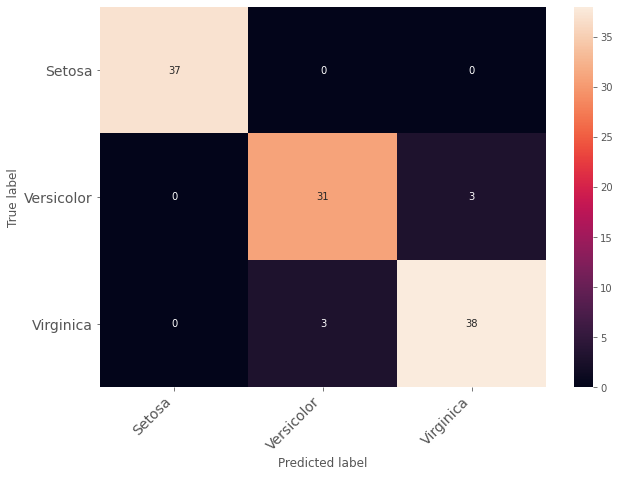

In [ ]:
pred_t = gnb.predict(X_train)
print_confusion_matrix(confusion_matrix(y_train, pred_t),["Setosa","Versicolor","Virginica"])

In [ ]:
print(classification_report(y_train, pred_t))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        37
         1.0       0.91      0.91      0.91        34
         2.0       0.93      0.93      0.93        41

    accuracy                           0.95       112
   macro avg       0.95      0.95      0.95       112
weighted avg       0.95      0.95      0.95       112



## Automated SMS spam filtering

Adaptado del notebook de Radim Rehurek presentado en la charla "Data Science with Python" 
University of Economics in Prague, Diciembre 2014. 
Enlace: https://radimrehurek.com/data_science_python/

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

### Step 1: Load data, look around

Skipping the *real* first step (fleshing out specs, finding out what is it we want to be doing -- often highly non-trivial in practice!), let's download the dataset we'll be using in this demo. Go to https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file. Unzip it under `data` subdirectory. You should see a file called `SMSSpamCollection`, about 0.5MB in size:

```bash
$ ls -l data
total 1352
-rw-r--r--@ 1 kofola  staff  477907 Mar 15  2011 SMSSpamCollection
-rw-r--r--@ 1 kofola  staff    5868 Apr 18  2011 readme
-rw-r-----@ 1 kofola  staff  203415 Dec  1 15:30 smsspamcollection.zip
```

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip
!ls

--2020-10-20 21:51:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2020-10-20 21:51:46 (1.59 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  
readme	sample_data  SMSSpamCollection	smsspamcollection.zip


This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info):

In [ ]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
len(messages)

5574

A collection of texts is also sometimes called "corpus". Let's print the first ten messages in this SMS corpus:

In [ ]:
for message_no, message in enumerate(messages[:10]):
    print (message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message "ham" or "spam". The second column is the message itself.

This corpus will be our labeled training set. Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to do the work for us:

In [ ]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


With `pandas`, we can also view aggregate statistics easily:

In [ ]:
messages.groupby('label').describe().T

label                              ham                                               spam
message count                     4827                                                747
        unique                    4518                                                653
        top     Sorry, I'll call later  Please call our customer service representativ...
        freq                        30                                                  4

How long are the messages?

In [ ]:
messages['length'] = messages['message'].map(lambda text: len(text))
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


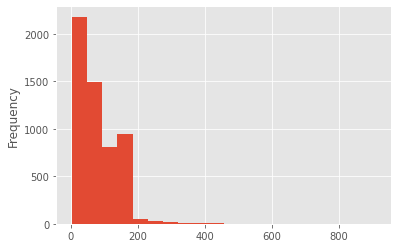

In [ ]:
messages.length.plot(bins=20, kind='hist');

In [ ]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [ ]:
print (list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


In [ ]:
print (list(messages[messages.length > 900].index))

[1085]


Is there any difference in message length between spam and ham?


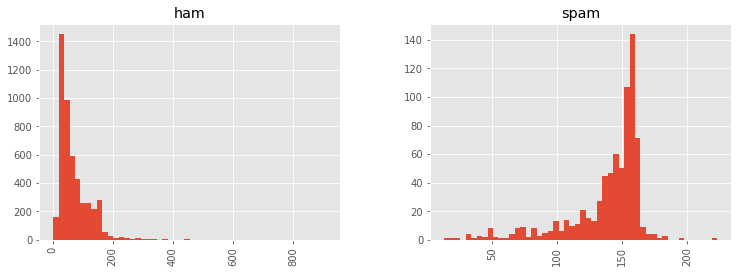

In [ ]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4));

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

### Step 2: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus.

To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [ ]:
vectorizer = TfidfVectorizer()
sms_tfidf = vectorizer.fit_transform(messages['message'].values)

print(sms_tfidf.shape)

(5574, 8713)


### Step 3: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.
The library sklearn.naive_bayes includes implementations of:
- GaussianNB
- MultinomialNB 
- BernoulliNB

## TAREA


#### **Pregunta 1:** ¿Por que usamos el clasificador Multinomial?

### Rpta. 
La razón principal para la utilización de la versión Multinomial del algoritmo Naive Bayes se debe al propósito específico del problema. En esta ocasión, se está trabajando con texto como data de entrada. La configuración de este como features implica la computación de diversas métricas (como el conteo) que recopilen información, p.ejem, de las palabras/token. Sin embargo, la versión NaiveBayes típica asume una fuerte independencia entre los features y, además, suele trabajar directamente con una distribución gaussiana para cada variable del conjunto de características. Esta asunción no es correcta para nuestros features debido a la naturaleza misma de los datos (nótese la composición del texto como un _corpus_). En ese sentido, resulta necesario asumir un tipo de distribución para los features del conjunto de datos textual. La distribución multinomial (que es una generalización de la distribución de probabilidad binomial típica) posibilita trabajar correctamente el conjunto de datos de texto como entrada. La idea central es dotar al modelo del conjunto de probabilidad de cada categoría (distribución categórica) según las palabras/token encontradas, asumiéndolas como variables aleatorias. Métricas como el conteo, la mediana, la moda, etc., resultan posibles bajo esta perspectiva.

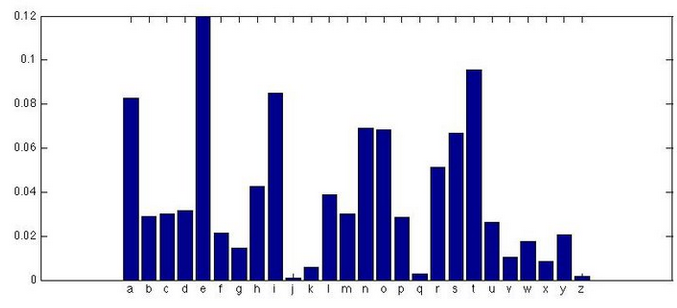

In [ ]:
classifier = MultinomialNB()
targets = messages['label'].values
clf = classifier.fit(sms_tfidf, targets)

Let's try classifying our single random message:

In [ ]:
examples = ['Free entry in 3 a wkly comp', 'Hello my friend']
example_vector = vectorizer.transform(examples)
predictions = classifier.predict(example_vector)

print(predictions)

['spam' 'ham']


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

all_predictions = clf.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print(statistics)

Accuracy: 0.9761

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4827
        spam       1.00      0.82      0.90       747

    accuracy                           0.98      5574
   macro avg       0.99      0.91      0.94      5574
weighted avg       0.98      0.98      0.98      5574



Figure(720x504)


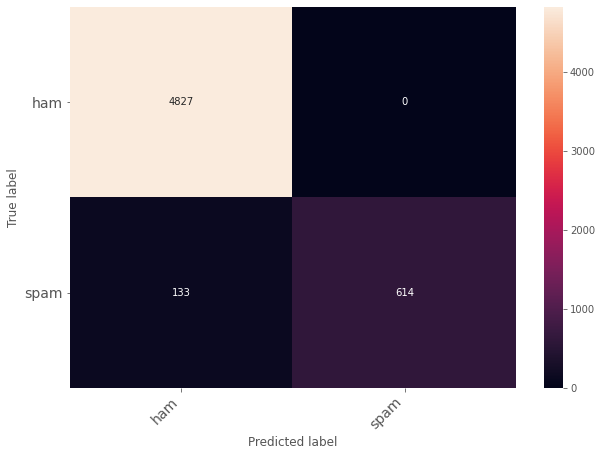

In [ ]:
print_confusion_matrix(cm,["ham", "spam"]) #DONDE 'HAM' son mensajes humanos y 'SPAM' correos spam

#en este caso, es prefereible que no existan missclasifications para true_labels HUMANS
#teniendo spam como mensajes verdaderos

By default, MultinomialNB uses the Additive Laplace smoothing (alpha = 1). Change the classifier to work with Lidstone smoothing. 

####  **Pregunta 2:** ¿A qué se debe la diferencia entre los resultados?

#### Rpta.

La diferencia entre los resultados se debe al efecto del _suavizado laplaciano_ versus el _suavizado lidstone_. Imagínese un conjunto de características cualesquiera, cuya probabilidad para una instancia específica:

$ \hat{Y_{j}} = P(y_{j}| x_{j}) = 0 $

Debido a que en:

$ P(y_{j}| x_{j}) = P(x_{j} | y_{j}) * P(y_{j}) / P(x_{j}) $ 

El componente

$  P(x_{j} | y_{j}) = 0 $

dado a que el conteo de uno de los features del conjunto de características $x$ para el label específico $y$ es 0.

La idea es evitar este escenario: se anula el cálculo de probabilidades. Asimismo, puede resultar un inconveniente ante la aparición OOF de valores $x_{j}$ para $y_{j}$. 

La solución es establecer un valor de probabilidad para el componente $ P(y_{j}| x_{j}) > 0 $. Este es el valor de $ α $. Si se utiliza un $ α = 1 $, se está trabajando con un suavizado laplaciano. Si $ α ∈$ $ ]0;1[ $, es un suavizado lidstone. Si $ α = 0 $, no existe efecto de suavizado alguno.

Las consecuencias de un valor $ α = 1 $ es, en efecto, mucho más bruscas que un valor $ α $ entre 0 y 1. Por tanto, el efecto lidstone tiende a ser mucho menos notorio al momento de su implementación.

Para este escenario en particular, el _suavizado lidstone_ (definido como $ α = 0.01 $) resultó ser mucho más efectivo que el valor $ α = 1 $ típico.

In [ ]:
classifier = MultinomialNB(alpha=0.01)  #alpha: el suavizado ahora usa lidstone con alpha menor a 1
targets = messages['label'].values
clf = classifier.fit(sms_tfidf, targets)

all_predictions = clf.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print(statistics)

Accuracy: 0.9991

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4827
        spam       1.00      0.99      1.00       747

    accuracy                           1.00      5574
   macro avg       1.00      1.00      1.00      5574
weighted avg       1.00      1.00      1.00      5574



Figure(720x504)


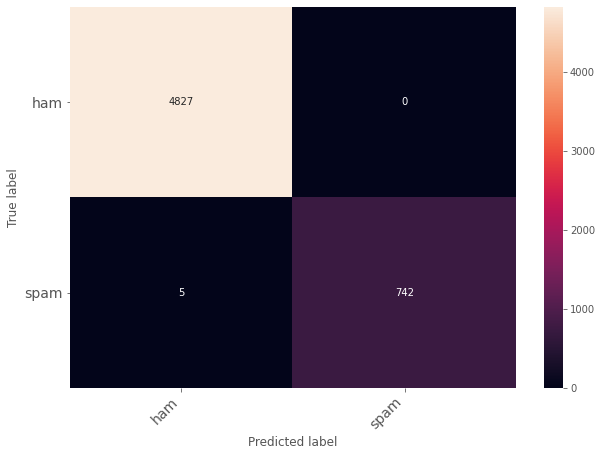

In [ ]:
print_confusion_matrix(cm,["ham", "spam"])

## Zoo Animal Classification

Trabajaremos con los datos de clasificación de animales de Zoológico de Kaggle (https://www.kaggle.com/uciml/zoo-animal-classification).


### Carga del dataset y exploración

Descargamos los archivos con el dataset y la descripción de las clases.

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1U2fTfqJL0Scs861k-CzVwbiIGlLq57lQ' -O zoo.csv
!wget 'https://drive.google.com/uc?export=download&id=1iRiQwdOTlAB6mlcT32wA3Lca41cRWYgy' -O class.csv

--2020-10-20 21:51:49--  https://drive.google.com/uc?export=download&id=1U2fTfqJL0Scs861k-CzVwbiIGlLq57lQ
Resolving drive.google.com (drive.google.com)... 74.125.20.102, 74.125.20.100, 74.125.20.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qlu6304ftbicdv558vq2s7ausvkqsvk4/1603230675000/13307417494834192396/*/1U2fTfqJL0Scs861k-CzVwbiIGlLq57lQ?e=download [following]
--2020-10-20 21:51:49--  https://doc-00-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qlu6304ftbicdv558vq2s7ausvkqsvk4/1603230675000/13307417494834192396/*/1U2fTfqJL0Scs861k-CzVwbiIGlLq57lQ?e=download
Resolving doc-00-3c-docs.googleusercontent.com (doc-00-3c-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to doc-00-3c-docs.googleusercontent.com (doc-00-3c-

In [ ]:
import pandas as pd

data = pd.read_csv("zoo.csv")
data.head(6)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1


In [ ]:
classdata = pd.read_csv("class.csv")
classdata

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


Descripción del conjunto de datos.

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
hair,101.0,0.425743,0.496921,0.0,0.0,0.0,1.0,1.0
feathers,101.0,0.198020,0.400495,0.0,0.0,0.0,0.0,1.0
eggs,101.0,0.584158,0.495325,0.0,0.0,1.0,1.0,1.0
milk,101.0,0.405941,0.493522,0.0,0.0,0.0,1.0,1.0
airborne,101.0,0.237624,0.427750,0.0,0.0,0.0,0.0,1.0
aquatic,101.0,0.356436,0.481335,0.0,0.0,0.0,1.0,1.0
predator,101.0,0.554455,0.499505,0.0,0.0,1.0,1.0,1.0
toothed,101.0,0.603960,0.491512,0.0,0.0,1.0,1.0,1.0
backbone,101.0,0.821782,0.384605,0.0,1.0,1.0,1.0,1.0
breathes,101.0,0.792079,0.407844,0.0,1.0,1.0,1.0,1.0


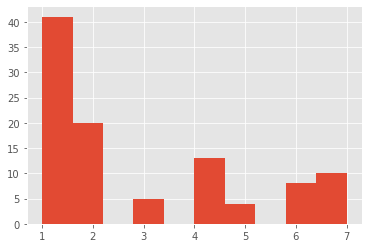

In [ ]:
data.class_type.hist()

### Preprocesamiento de datos

Separamos las características de las clases.

In [ ]:
def preprocess(data, class_col):
    X = data.iloc[:, 1:class_col]  # Descartamos la última columna, correspondiente a la clase y la primera correspondiente al nombre del animal
    y = data.iloc[:, class_col]  # Separamos en y la clase
    return X, y

In [ ]:
data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Vemos que la característica legs no es binaria. Vamos a descartarla para utilizar solo las características binarias. Adicionalmente, descartamos el nombre del animal que no nos da información útil para la clasificación.

In [ ]:
no_legs_data = data.drop(['legs'],axis=1)
no_legs_data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,1


In [77]:
X, y = preprocess(no_legs_data, 16)
X.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1


Separamos los conjuntos en entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Entrenamiento y evaluación del clasificador bernoulli.

Realizamos el entrenamiento. 

In [ ]:
from sklearn.naive_bayes import BernoulliNB
#son varios animales, por eso que usamos bernoulli
bnb = BernoulliNB() 
model = bnb.fit(X_train, y_train)
print('Accuracy of BernoulliNB classifier on training set: {:.2f}'
     .format(bnb.score(X_train, y_train)))
print('Accuracy of BernoulliNB classifier on test set: {:.2f}'
     .format(bnb.score(X_test, y_test)))

Accuracy of BernoulliNB classifier on training set: 0.97
Accuracy of BernoulliNB classifier on test set: 0.96


### **Pregunta 3:** Naive Bayes

Hemos descartado la característica legs que contiene información valiosa sobre los animales. Es posible usar el clasificador bernoulli naive bayes incluyendo esta característica. Realice las modificaciones al modelo bnb definido previamente para trabajar con la clase legs. Mantenga el random_state=0 al realizar la partición en entrenamiento y validación.



In [80]:
#one hot encoding sobre la característica 'leg' original
newX = pd.concat([X, pd.get_dummies(data.legs, prefix='legs')], axis=1)

In [82]:
#redefinimos el nuevo conjunto de caracter´siticas
newX.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize,legs_0,legs_2,legs_4,legs_5,legs_6,legs_8
0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0
1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0
2,0,0,1,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0
4,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0


In [86]:
#separamos conjunto de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(newX, y, random_state=0)

In [87]:
X_train

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize,legs_0,legs_2,legs_4,legs_5,legs_6,legs_8
6,1,0,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0
100,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0
82,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0
76,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0
60,0,0,1,0,0,1,1,1,1,0,0,1,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
67,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0
64,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0
47,1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0


In [88]:
#aplicamos bernouille con base al nuevo conjunto de características (inc. 'legs')
model = bnb.fit(X_train, y_train)
print('Accuracy of BernoulliNB classifier on training set: {:.2f}'
     .format(bnb.score(X_train, y_train)))
print('Accuracy of BernoulliNB classifier on test set: {:.2f}'
     .format(bnb.score(X_test, y_test)))

Accuracy of BernoulliNB classifier on training set: 0.96
Accuracy of BernoulliNB classifier on test set: 1.00
